# Skydio X2 dynamical parameters identification

## Problem formulation

Given trajectory log from drone, we want to estimate its dynamical parameters, namemy, mass, inertia and vector to center of mass.

$$
\mathbf{\theta} = \begin{bmatrix} m, mr_x, mr_y, mr_z, I_{xx}, I_{xy}, I_{yy}, I_{xz}, I_{yz}, I_{zz} \end{bmatrix}^T
$$

In this notebook, an LTV LQR controller is implemented to gather data and identify parameters later.


In [1]:
import numpy as np
import mujoco
import copy
import scipy
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are as dare

from mujoco_sysid import mj_bodyRegressor

In [2]:
model = mujoco.MjModel.from_xml_path(MJCF_PATH)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

for act_id in range(4):
    model.actuator(act_id).ctrlrange = np.array([-1e4, 1e4])

model.opt.timestep = 1e-3

In [3]:
# load trajectory
traj = np.load("../data/trajectories/skydio.npz")
tf = traj["t"]

q_data = traj["q"].T
v_data = traj["v"].T
u_data = traj["u"].T
N_DATA = q_data.shape[1]
t_data = np.linspace(0, tf, N_DATA)

q_traj = scipy.interpolate.interp1d(t_data, q_data, axis=1, kind="linear")
v_traj = scipy.interpolate.interp1d(t_data, v_data, axis=1, kind="linear")
u_traj = scipy.interpolate.interp1d(t_data[:-1], u_data, axis=1, kind="linear")
N_TRAJ = int(tf / model.opt.timestep)
traj["q"].shape, traj["v"].shape, traj["u"].shape

((41, 7), (41, 6), (40, 4))

In [4]:
def dlqr_ltv(A, B, Q, R):
    """Discrete time LTV LQR controller"""
    N = np.shape(A)[0]
    n = np.shape(A)[1]
    m = np.shape(B)[2]

    # Matrix to store cost-to-go
    P = np.zeros((N, n, n))
    P[-1] = Q
    # Matrix to store gains
    K = np.zeros((N, m, n))

    for k in range(N - 2, -1, -1):
        # Compute the LQR gain
        invM_k = np.linalg.inv(R + B[k].T @ P[k + 1] @ B[k])
        K[k] = invM_k @ B[k].T @ P[k + 1] @ A[k]
        Ac_k = A[k] - B[k] @ K[k]  # Update with difference Riccati equation
        # Compute cost-to-go matrix
        P[k] = Q + K[k].T @ R @ K[k] + Ac_k.T @ P[k + 1] @ Ac_k

    return K, P


def dlqr(A, B, Q, R):
    """Discrete time LTI LQR"""
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

In [5]:
# find linearization over trajectory
def linearize(q, v, u) -> tuple[np.ndarray, np.ndarray]:
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = u
    newdata.qpos = q
    newdata.qvel = v

    # 4. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6  # model.opt.timestep
    flg_centered = False
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    return A, B

In [6]:
# linearize around trajectory
A_traj = []
B_traj = []

traj_t = traj["t"]

traj_dt = model.opt.timestep

for i in range(N_DATA):
    t = i * traj_dt
    A, B = linearize(q_traj(t), v_traj(t), u_traj(t))
    A_traj.append(A)
    B_traj.append(B)

Q = np.eye(2 * model.nv)
R = np.array(
    [
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
    ]
)
R = np.eye(4) * 0.3

# find gains for stabilization at the end
A_stab, B_stab = linearize(
    q_data[:, -1],
    np.zeros(model.nv),
    np.ones(4) * 1.325 * 9.81 / 4,
)
# find gains for stabilization at the end
K_stab, P_stab = dlqr(A_stab, B_stab, Q, R)
K, _ = dlqr_ltv(A_traj, B_traj, Q, R)

# Actual parameters

Spacial inertia matrix is defined as:

$$
M=\left[\begin{array}{cc}
m 1_3 & -m S(c) \\
m S(c) & I_B
\end{array}\right] .
$$

Where:

- $m \in \mathbb{R}$ is the mass of the rigid body,
- $c \in \mathbb{R}^3$ is the center of mass of the rigid body, expressed in the frame $B$,
- $I_B \in \mathbb{R}^{3 \times 3}$ is the 3D inertia matrix of the rigid body, expressed with the orientation of frame $B$ and with respect to the frame $B$ origin.

The $6 \mathrm{D}$ inertia matrix is parametrized by 10 parameters, that are defined as $\pi \in \mathbb{R}^{10}$ :

$$
\pi=\left[\begin{array}{c}
m \\
m c \\
\operatorname{vech}\left(I_B\right)
\end{array}\right] .
$$


In [7]:
sparceM = np.zeros((6, 6))

mujoco.mj_step(model, data)
mujoco.mj_fullM(model, sparceM, data.qM)

mSrc = sparceM[3:6, :3]
mrc = np.array([mSrc[2, 1], mSrc[0, 2], mSrc[1, 0]])
Ib = sparceM[3:6, 3:6]
vechIb = np.array([Ib[0, 0], Ib[0, 1], Ib[1, 1], Ib[0, 2], Ib[1, 2], Ib[2, 2]])
parameters = np.array([sparceM[0, 0], *mrc, *vechIb])

with np.printoptions(precision=3, suppress=True):
    print(parameters)

[ 1.325  0.     0.     0.072  0.041  0.     0.029 -0.002  0.     0.061]


In [8]:
FRAMERATE = 20  # Hz

# store different in tangent space between configurations
dq = np.zeros(model.nv)

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = q_traj(0)
data.qvel = np.zeros(6)
last_time = 0
phase = 0

hist_qpos = []
hist_target_qpos = []

frames = []
k = 0

LHS = []
RHS = []

while data.time < tf + 3.0:
    hist_qpos.append(data.qpos.copy())
    t = data.time

    k = int(t / (tf / N_DATA))

    if t < tf - 0.1:
        q_target = q_traj(t)
        v_target = v_traj(t)
        u_target = u_traj(t)

        # Get state difference dx.
        mujoco.mj_differentiatePos(model, dq, 1, q_target, data.qpos.copy())

        dv = data.qvel.copy() - v_target
        dx = np.hstack((dq, dv)).T

        # LQR control law.
        data.ctrl = u_target - K[k] @ dx
    else:
        # stabilize around the last configuration
        q_target = q_data[:, -1]
        v_target = np.zeros(model.nv)
        u_target = np.ones(4) * 1.325 * 9.81 / 4

        # Get state difference dx.
        mujoco.mj_differentiatePos(model, dq, 1, q_target, data.qpos.copy())

        dv = data.qvel.copy() - v_target
        dx = np.hstack((dq, dv)).T

        # LQR control law.
        data.ctrl = u_target - K_stab @ dx

    mujoco.mj_step(model, data)

    hist_target_qpos.append(q_target.copy())

    # Regressor computation

    datacopy = copy.copy(data)
    mujoco.mj_inverse(model, datacopy)

    # Fill matrices
    regressor = mj_bodyRegressor(model, datacopy, 1)
    LHS.extend(regressor)

    # force = datacopy.qfrc_inverse.copy()
    force2 = datacopy.qfrc_actuator.copy()
    force2[:3] = datacopy.xmat[1].reshape(3, 3).T @ force2[:3]
    RHS.extend(force2)

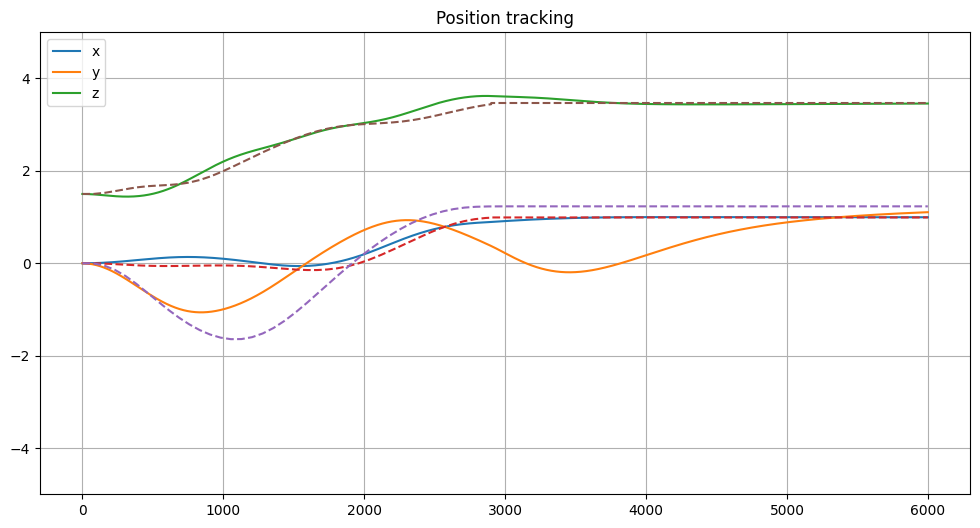

In [9]:
hist_qpos = np.array(hist_qpos)
hist_target_qpos = np.array(hist_target_qpos)

plt.figure(figsize=(12, 6))
plt.title("Position tracking")
plt.plot(hist_qpos[:, :3], label=["x", "y", "z"])
plt.plot(hist_target_qpos[:, :3], linestyle="--")
plt.ylim([-5, 5])

plt.legend()
plt.grid()

plt.show()

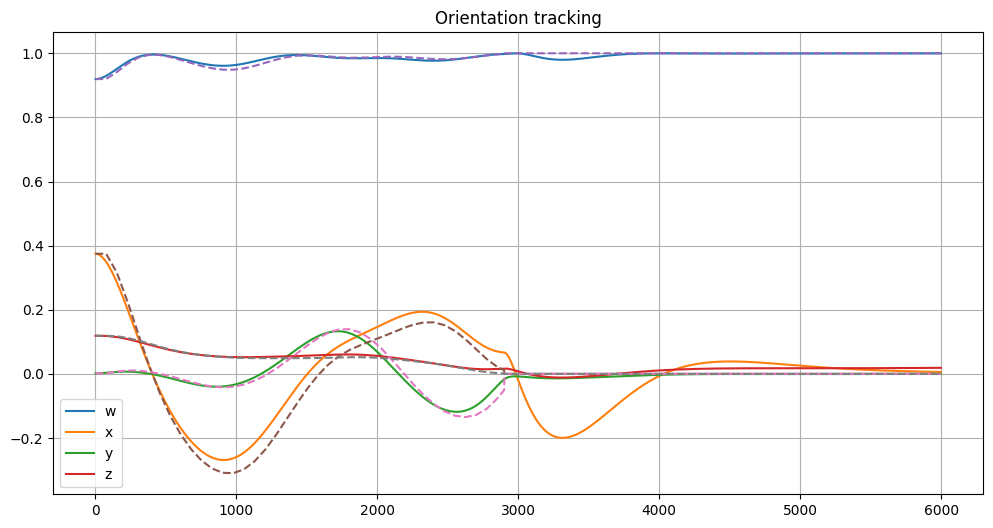

In [10]:
plt.figure(figsize=(12, 6))
plt.title("Orientation tracking")
plt.plot(hist_qpos[:, 3:], label=["w", "x", "y", "z"])
plt.plot(hist_target_qpos[:, 3:], linestyle="--")

plt.legend()
plt.grid()

plt.show()

In [11]:
from mujoco.minimize import least_squares

id2, _ = least_squares(
    np.zeros(10),
    lambda x: LHS @ x - RHS,
)

with np.printoptions(precision=3, suppress=True):
    print("Identified parameters", id2)
    print("Actual parameters", parameters)

iter: 0    y: 5.698e+05  log10mu: -inf  ratio: 1        dx: 1.3      reduction: 5.7e+05
iter: 1    y: 40.79      log10mu: -inf  ratio: 5.5e+03  dx: 2.5e-12  reduction: 7.1e-15
Terminated after 1 iterations: norm(dx) < tol. y: 40.79, Residual evals: 23
total time 335.9ms of which residual 99.3%
Identified parameters [ 1.33  -0.     0.001  0.072  0.041  0.     0.029 -0.004 -0.     0.083]
Actual parameters [ 1.325  0.     0.     0.072  0.041  0.     0.029 -0.002  0.     0.061]


## Conclusion:

Parameters are identified at acceptable level